In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
target_idx = 2
summer_idx = 1

In [17]:
class NIOM:
    def __init__(self):
        pass
    def predict(self, X):
        preds = []
        X["Energy"] = X.Energy.rolling(15).mean()
        # print(X)
        for _, ser in X.groupby("Day"):
            energy_night = ser[(ser.Time > 1)&(ser.Time < 8)].Energy
            p_ave = energy_night.max()
            # print(f"p_ave: {p_ave}")

            energy_day = ser[(ser.Time >= 12)&(ser.Time < 44)].Energy
            pred = [1 if x > p_ave else 0 for x in energy_day]
            preds += pred
        return preds

In [18]:
target_X_all = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_X_train_niom.csv")
num_days = int(target_X_all.shape[0]/48)
target_X_all["Day"] = [i for i in range (num_days) for _ in range(48)]

target_X = target_X_all[(target_X_all.Time >= 12)&(target_X_all.Time < 44)]
target_X = target_X.reset_index(drop=True)
target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_Y_train_niom.csv")[target_X.Season==summer_idx]

target_X_all = target_X_all[target_X_all.Season==summer_idx]

In [19]:
niom = NIOM()
pred_y = niom.predict(target_X_all)

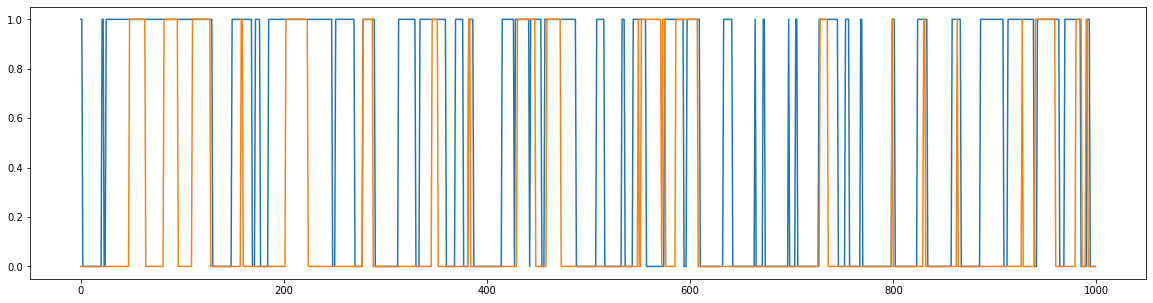

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(target_y_task.Occupancy[:1000])
plt.plot(pred_y[:1000])

In [21]:
sum(np.array(pred_y) == target_y_task.values.reshape(-1))/len(pred_y)

0.5873161764705882